In [1]:
import numpy as np
import astropy
from astropy.io import ascii
from astropy.table import Table
import scipy.linalg as la
import pandas as pd
import requests
import uncertainties
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u
import json
import os
from scipy.optimize import curve_fit
import time


In [2]:
from uncertainties import unumpy as unp


In [3]:
from matplotlib import rc
# Default properties:
# rc('text', usetex=True)
rc('font', family='serif')
#rc('font', serif='palatino')
#rc('font', weight='bolder')
rc('mathtext', default='sf')
rc("lines", markeredgewidth=2)
rc("lines", linewidth=3)
rc('axes', labelsize=30)
rc("axes", linewidth=2)
rc('xtick', labelsize=28)
rc('ytick', labelsize=28)
rc('legend', fontsize=20)
rc('xtick.major', pad=8)
rc('ytick.major', pad=8)
rc('xtick.major', size=13)
rc('ytick.major', size=13)
rc('xtick.major', width=3)
rc('ytick.major', width=3)
rc('xtick.minor', size=7)
rc('ytick.minor', size=7)
rc('xtick.minor', width=3)
rc('ytick.minor', width=3)


In [4]:
header = ["Exclusion Code",
          "D",
          "G",
          "Galaxy ID",
          "m-M",
          "err",
          "D (Mpc)",
          "Method",
          "REFCODE",
          "SN ID",
          "redshift (z)",
          "Hubble const.",
          "Adopted LMC modulus",
          "Date (Yr. - 1980)",
          "Notes"]
ned_data = pd.read_csv("./NED30.5.1-D-17.1.2-20200415.csv",
                       names=header, skiprows=13)


In [5]:
def getGalInfo(galname):
    # res_headers = {
    #     'Content-type': 'application/json',
    # }
    res_data = {
        'json': '{"name":{"v": "%s"}}' % galname
    }
    res = requests.post(
        'https://ned.ipac.caltech.edu/srs/ObjectLookup', data=res_data)
    return res.json()


In [6]:
def mod2dist(distance_modulus):
    return 10**(distance_modulus / 5)*10 / 1e6  # in unit Mpc


In [7]:
trgb_method = ned_data[ned_data["Method"] == "TRGB"]


In [8]:
if not os.path.exists('./trgb_reshift.json'):
    trgb_host_info = {}
    for index, row in trgb_method.iterrows():
        try:
            gal_info = getGalInfo(row["Galaxy ID"])["Preferred"]
        except:
            print(row["Galaxy ID"], "no data")
            continue
        redshift = gal_info["Redshift"]["Value"]
        z_err = gal_info["Redshift"]["Uncertainty"]
        paper_reference = gal_info["Redshift"]["RefCode"]
        if redshift is None:
            print(row["Galaxy ID"], " redshift is null")
            continue
        trgb_host_info[row["Galaxy ID"]] = (redshift, z_err, paper_reference)
        time.sleep(1)
    with open("trgb_reshift.json", "w") as fout:
        json.dump(trgb_host_info, fout)
else:
    with open("./trgb_reshift.json", "r") as fread:
        trgb_host_info = json.load(fread)


In [9]:
# plt.figure(figsize=(8, 6))
trgb_d = []
trgb_vr = []
trgb_err_vr = []
trgb_err_d = []
max_paper = None
max_num = 0
for paper in trgb_method['REFCODE']:
    if max_num < sum(trgb_method['REFCODE'] == paper):
        max_num = sum(trgb_method['REFCODE'] == paper)
        max_paper = paper
trgb_method_paper = trgb_method[trgb_method['REFCODE'] == max_paper]
# print(max)
for index, row in trgb_method_paper.iterrows():
    # print(bh_host_info[row["Galaxy ID"]][0])
    # if 3.35 < row["D (Mpc)"] and  row["D (Mpc)"] < 3.8:
    #     continue
    if row["Galaxy ID"] not in trgb_host_info.keys():
        # print("not plot %s" % row["Galaxy ID"])
        continue
    # 3 sigma cut
    if trgb_host_info[row["Galaxy ID"]][0] < 3 * trgb_host_info[row["Galaxy ID"]][1]:
        # print(index, row["Galaxy ID"], "rejected by 3 sigma cut")
        continue
    # if row["D (Mpc)"] < 10 and (const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][0]).value > 3000:
        # print(row)
        # print(trgb_host_info[row["Galaxy ID"]][0], trgb_host_info[row["Galaxy ID"]][1], trgb_host_info[row["Galaxy ID"]][2])
    u_dist = mod2dist(unp.uarray(row["m-M"], row["err"]))
    trgb_d.append(u_dist.n)
    trgb_err_d.append(u_dist.s)
    trgb_vr.append(const.c.to(u.km/u.s) * trgb_host_info[row["Galaxy ID"]][0])
    trgb_err_vr.append(const.c.to(u.km/u.s) *
                       trgb_host_info[row["Galaxy ID"]][1])
trgb_d = np.array(trgb_d)
trgb_err_d = np.array(trgb_err_d)
trgb_vr = np.array([i.value for i in trgb_vr])
trgb_err_vr = np.array([i.value for i in trgb_err_vr])
# plt.ylim([0, 2e3])


In [10]:
def hubble(d, H0):
    return H0 * d

def inv_hubble(v, H0):
    return v / H0

[90.6113409] [[13.27771115]]


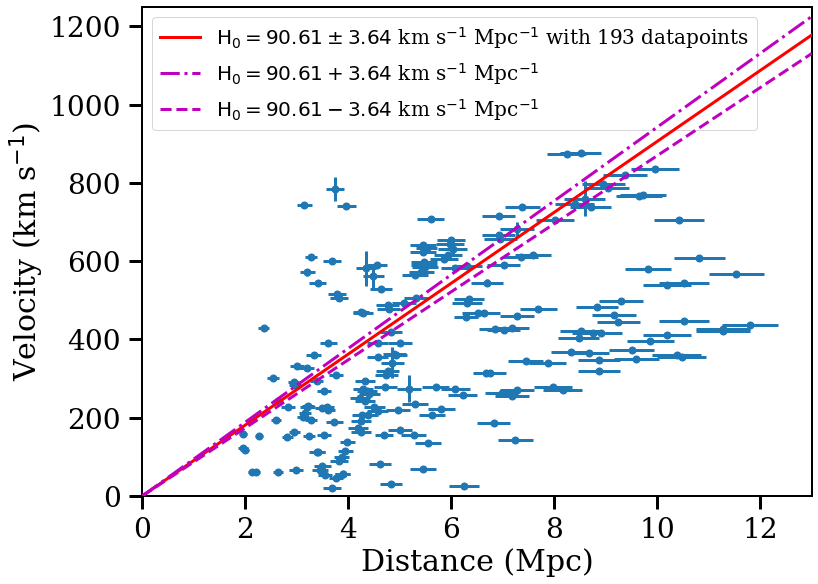

In [49]:
remove_value = (trgb_vr > 1.5e3) | (trgb_d > 15)
dist_cut = (trgb_d > 3 * trgb_err_d)
z_cut = (trgb_vr > 3 * trgb_err_vr)
mask = (trgb_d > 1.5) & ~remove_value & dist_cut & z_cut
trgb_popt, trgb_pcov = curve_fit(inv_hubble, trgb_vr[mask], trgb_d[mask], sigma=trgb_err_d[mask])
print(trgb_popt, trgb_pcov)
plt.figure(figsize=(12, 9))
plt.errorbar(trgb_d[mask], trgb_vr[mask], fmt='o',
             yerr=trgb_err_vr[mask], xerr=trgb_err_d[mask])
xarr = np.linspace(0, 13)
plt.plot(xarr, trgb_popt * xarr, "r", label=r"$H_0=%.2f \pm %.2f$ km s$^{-1}$ Mpc$^{-1}$ with %s datapoints" %
         (trgb_popt, np.sqrt(trgb_pcov), sum(mask)), zorder=1e10)
plt.plot(xarr, (trgb_popt + np.sqrt(trgb_pcov[0])) * xarr, "m-.", label=r"$H_0=%.2f + %.2f$ km s$^{-1}$ Mpc$^{-1}$" %
         (trgb_popt, np.sqrt(trgb_pcov)), zorder=1e10)
plt.plot(xarr, (trgb_popt - np.sqrt(trgb_pcov[0])) * xarr, "m--", label=r"$H_0=%.2f - %.2f$ km s$^{-1}$ Mpc$^{-1}$" %
         (trgb_popt, np.sqrt(trgb_pcov)), zorder=1e10)
plt.xlabel("Distance (Mpc)")
plt.ylabel("Velocity (km s$^{-1}$)")
plt.legend(loc="upper left")
plt.xlim([0, 13])
plt.ylim([0, 1250])
# plt.show()
plt.savefig("trbg_single_paper_ivar.pdf", bbox_inches="tight")


In [12]:
from hyperfit.linfit import LinFit

In [13]:
trgb_data, trgb_cov = np.empty((2, trgb_d[mask].shape[0])), np.empty((2, 2, trgb_d[mask].shape[0]))
for i, (x, y, ex, ey) in enumerate(zip(trgb_d[mask], trgb_vr[mask], trgb_err_d[mask], trgb_err_vr[mask])):
    trgb_data[:, i] = np.array([x, y])
    trgb_cov[:, :, i] = np.array([[ex**2, 0], [0, ey**2]])
# trgb_data = np.array([trgb_d[mask], trgb_vr[mask]])
# trgb_cov = np.array([[[trgb_err_d[mask][i]**2, 0], [0, trgb_err_vr[mask][i]**2]] for i in range(len(trgb_d[mask]))]).T

In [14]:
hf = LinFit(trgb_data, trgb_cov)  

In [18]:
bounds = ((-1e-2, 100), (-1e-2, 3000), (1e-5, 1000))
params, sigma_y, loglike = hf.optimize(bounds=bounds)
print(params, sigma_y, loglike)

[78.14447157 -0.39075796] 208.78938344430483 -286.5986348804515


In [20]:
mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=True)
print(np.mean(mcmc_samples, axis=1), np.std(mcmc_samples, axis=1))

     fun: array([286.59862862])
     jac: array([-2.33264018e+01,  9.31056127e+02,  1.78488336e-03])
 message: 'Optimization terminated successfully.'
    nfev: 6552
     nit: 143
 success: True
       x: array([ 4.99986642e-03, -6.39826463e-05,  2.65408338e+00])


100%|██████████| 1000/1000 [00:00<00:00, 1483.90it/s]


Niterations/Max Iterations:  1000 / 100000
Integrated ACT/Min Convergence Iterations:  [70.12793322 69.39364735 34.02403812] / 3506.396660819333


100%|██████████| 1000/1000 [00:00<00:00, 1554.83it/s]


Niterations/Max Iterations:  2000 / 100000
Integrated ACT/Min Convergence Iterations:  [50.15881876 50.49247983 41.24914065] / 2524.6239915472775


100%|██████████| 1000/1000 [00:00<00:00, 1564.91it/s]


Niterations/Max Iterations:  3000 / 100000
Integrated ACT/Min Convergence Iterations:  [47.64987946 48.87945325 42.79711018] / 2443.972662687245


100%|██████████| 1000/1000 [00:00<00:00, 1602.03it/s]


Niterations/Max Iterations:  4000 / 100000
Integrated ACT/Min Convergence Iterations:  [53.62350211 55.2982878  44.49972216] / 2764.9143900426984


100%|██████████| 1000/1000 [00:00<00:00, 1554.89it/s]


Niterations/Max Iterations:  5000 / 100000
Integrated ACT/Min Convergence Iterations:  [50.08219901 50.71788263 48.34147384] / 2535.8941312735897


100%|██████████| 1000/1000 [00:00<00:00, 1580.74it/s]


Niterations/Max Iterations:  6000 / 100000
Integrated ACT/Min Convergence Iterations:  [56.33946451 56.81879476 49.46716706] / 2840.93973814065


100%|██████████| 1000/1000 [00:00<00:00, 1579.60it/s]


Niterations/Max Iterations:  7000 / 100000
Integrated ACT/Min Convergence Iterations:  [52.4412615  52.74137181 51.17567464] / 2637.0685904886964


100%|██████████| 1000/1000 [00:00<00:00, 1534.95it/s]

Niterations/Max Iterations:  8000 / 100000
Integrated ACT/Min Convergence Iterations:  [53.36798201 53.86155371 51.5456749 ] / 2693.0776854232045
[ 77.0780852    6.66423858 209.04950749] [ 2.79390694  4.76250399 13.12757707]


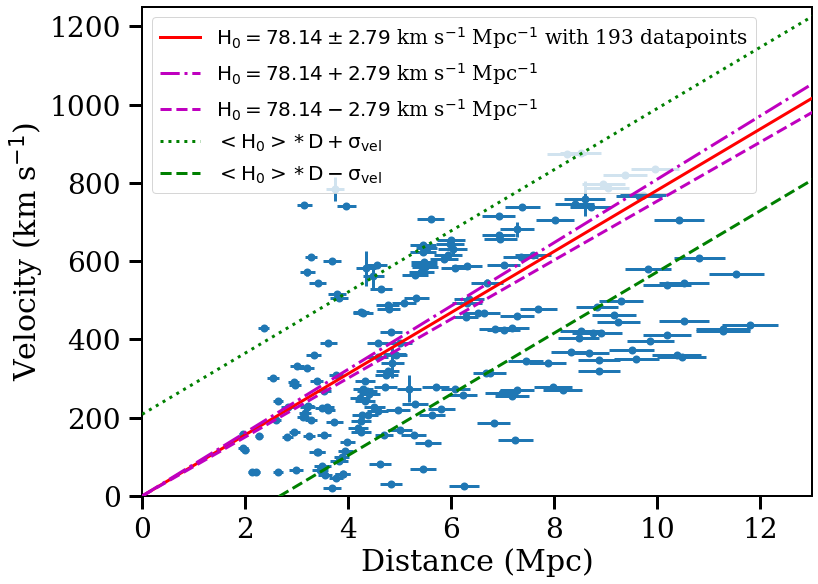

In [45]:
plt.figure(figsize=(12, 9))
plt.errorbar(trgb_d[mask], trgb_vr[mask], fmt='o',
             yerr=trgb_err_vr[mask], xerr=trgb_err_d[mask])
xarr = np.linspace(0, 15)
H0 = params[0]
H0_err = np.std(mcmc_samples, axis=1)[0]
plt.plot(xarr, H0 * xarr, "r", label=r"$H_0=%.2f \pm %.2f$ km s$^{-1}$ Mpc$^{-1}$ with %s datapoints" %
         (H0, H0_err, sum(mask)), zorder=1e10)
plt.plot(xarr, (H0 + H0_err) * xarr, "m-.", label=r"$H_0=%.2f + %.2f$ km s$^{-1}$ Mpc$^{-1}$" %
         (H0, H0_err), zorder=1e10)
plt.plot(xarr, (H0 - H0_err) * xarr, "m--", label=r"$H_0=%.2f - %.2f$ km s$^{-1}$ Mpc$^{-1}$" %
         (H0, H0_err), zorder=1e10)
plt.plot(xarr, H0 * xarr + sigma_y, "g:", label=r"$<H_0> * D + \sigma_{vel}$" %
         (sigma_y), zorder=1e10)
plt.plot(xarr, (H0) * xarr - sigma_y, "g--", label=r"$<H_0> * D - \sigma_{vel}$" %
         (sigma_y), zorder=1e10)
plt.xlabel("Distance (Mpc)")
plt.ylabel("Velocity (km s$^{-1}$)")
plt.legend(loc="upper left")
plt.xlim([0, 13])
plt.ylim([0, 1250])
# plt.show()
plt.savefig("trbg_single_paper_hyperfit.pdf", bbox_inches="tight", pad_inches=0.1)


In [ ]:
hf.vert_scat

208.8041162303801

In [ ]:
trgb_data.shape

(2, 195)

In [ ]:
cov.shape

NameError: name 'cov' is not defined

In [ ]:
trgb_cov = np.array([[[trgb_err_d[mask][i]**2, 0], [0, trgb_err_vr[mask][i]**2]] for i in range(len(trgb_d[mask]))]).T

In [ ]:
trgb_cov.shape

(2, 2, 171)